#Рабочий вариант

Начиная с этого момента и дальше находятся рабочие куски кода

In [2]:
pip install --upgrade scipy

     |████████████████████████████████| 27.4MB 135kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


Здесь нужно перезапустиить среду выполнения, затем продолжить запускать ячейки
Это нужно, потому что tsfresh для установки требует последнюю версию scipy, а для переустановки последней версии, нужно перезапустить среду

##Подключаем библиотеки

In [1]:
import os
from urllib.request import urlretrieve
import scipy
import scipy.io as sio

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
pip install tsfresh

     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 716kB 26.7MB/s 
     |████████████████████████████████| 1.1MB 36.8MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 1.3MB 39.6MB/s 
     |████████████████████████████████| 122kB 32.8MB/s 
ERROR: googleapis-common-protos 1.53.0 has requirement protobuf>=3.12.0, but you'll have protobuf 3.11.2 which is incompatible.
ERROR: google-api-core 1.26.3 has requirement protobuf>=3.12.0, but you'll have protobuf 3.11.2 which is incompatible.
ERROR: distributed 2021.6.0 has requirement dask==2021.06.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3
  Found existing installation: prot

In [3]:
from tsfresh.feature_extraction.settings import MinimalFCParameters, EfficientFCParameters, ComprehensiveFCParameters
from tsfresh import extract_features, select_features
import tsfresh

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as Rand_Forest
from sklearn.linear_model import SGDClassifier as Linear
from sklearn.model_selection import train_test_split

from random import randint

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Загружаем данные

In [4]:
Dataset_names = ['20140526_277um',
                 '20140527_421um',
                 '20140528_565um',
                 'BWRat17_121712',
                 'BWRat17_121912',
                 'BWRat18_020513',
                 'BWRat19_032413',
                 'BWRat19_032513',
                 'BWRat20_101013',
                 'BWRat20_101513',
                 'BWRat21_121113',
                 'BWRat21_121613',
                 'Bogey_012615',
                 'Dino_061914_ACC',
                 'Dino_061914_mPFC',
                 'Dino_062014_ACC',
                 'Dino_062014_mPFC',
                 'Dino_072114_mPFC',
                 'Dino_072314_mPFC',
                 'Dino_072414_mPFC',
                 'Rizzo_022615',
                 'Rizzo_022715',
                 'Splinter_020515',
                 'Splinter_020915',
                 'Templeton_032415']
Dataset_size = [0] * len(Dataset_names)

In [5]:
os.makedirs("Data_mat",exist_ok=True) 
for i in range(len(Dataset_names)):
  data_url = "https://raw.githubusercontent.com/KAD1029/Neural_Activity/master/All_Mat_Files/{}/{}".format(Dataset_names[i], Dataset_names[i])
  data_path = "Data_mat/{}".format(Dataset_names[i])
  urlretrieve(data_url + '_CellIDs.mat', data_path + '_CellIDs.mat')
  urlretrieve(data_url + '_SStable.mat', data_path + '_SStable.mat')
os.makedirs("Data_csv",exist_ok=True)
os.makedirs("Types_csv", exist_ok=True)

In [6]:
for i in range(len(Dataset_names)):
  Mat_file = sio.loadmat(f'Data_mat/{Dataset_names[i]}_SStable.mat')
  ar = Mat_file['S_CellFormat'][0]
  Dataset_size[i] = len(ar)
  for k in range(Dataset_size[i]):
    np.savetxt(f"Data_csv/Neuron_data_{i}_{k}.csv", ar[k], delimiter="\n")

In [7]:
for i in range(len(Dataset_names)):
  Mat_file = sio.loadmat(f'Data_mat/{Dataset_names[i]}_CellIDs.mat')
  ar = Mat_file['CellIDs'][0][0]
  neuron_types = []
  for k in range(1, Dataset_size[i] + 1):
    if k in ar[4] :
      neuron_types.append(1)
    else:
      neuron_types.append(-1)
  np.savetxt(f"Types_csv/Neuron_types_{i}.csv", neuron_types, delimiter="\n")

##Преобразуем данные в удобный вид

In [8]:
Neuron_data = []
for i in range(len(Dataset_names)):
  for k in range(Dataset_size[i]):
    f = open(f"Data_csv/Neuron_data_{i}_{k}.csv")
    tmp = list(map(float, f.read().split()))
    Neuron_data.append(tmp)

In [9]:
Neuron_types = []
for i in range(len(Dataset_names)):
  f = open(f"Types_csv/Neuron_types_{i}.csv")
  tmp = list(map(float, f.read().split()))

  Neuron_types += tmp

##Готовим данные к обучению

In [10]:
tmp1 = []
tmp2 = []
for i in range(int(len(Neuron_data))):
  tmp1 += Neuron_data[i]
  tmp2 += [i] * len(Neuron_data[i])

X = pd.DataFrame()
X[0] = pd.Series(tmp1)
X[1] = pd.Series(tmp2)

In [11]:
X_ts_main = [X]
noise_list = [0, 0.1, 1.0, 10.0, 100.0]

for i in range(1, len(noise_list)) :
  X_tmp = X.copy()
  noise = np.random.normal(0, noise_list[i], X_tmp[0].shape)
  X_tmp[0] = X_tmp[0] + noise
  X_ts_main.append(X_tmp)

for k in range(len(X_ts_main)) :
  print(f'{noise_list[k]:<10}', end = '   ')

print('\n')

for i in range(40) :
  for k in range(len(X_ts_main)) :
    print(f'{X_ts_main[k][0][i]:<10.5f}', end = '   ')
  print()

0            0.1          1.0          10.0         100.0        

5.68395      5.73766      5.29158      9.28734      12.75134     
13.38375     13.36204     13.59209     20.57390     160.11045    
13.47865     13.52331     13.83989     15.17467     -82.48689    
24.32115     24.23553     24.67141     27.53929     54.58616     
25.74335     25.79717     24.84439     23.83126     -31.14486    
39.11725     39.05437     38.85659     38.34101     -54.39278    
39.61440     39.67242     41.16199     50.64992     -48.62093    
51.89055     51.85101     51.87399     54.75079     -80.34842    
70.55300     70.59888     71.86240     65.37327     124.45576    
75.34245     75.40112     74.31022     78.48829     40.89552     
77.81465     77.65586     78.78061     79.54371     157.69699    
77.83560     77.99848     76.95132     90.13829     174.76323    
85.85180     85.80884     85.39981     89.45837     91.81142     
88.98765     88.99219     88.55420     74.60266     206.81323    
89.16775 

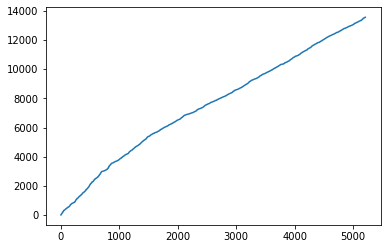

In [12]:
X_plot = [i for i in range(len(Neuron_data[0]))]
plt.plot(X_plot, X_ts_main[0][0][0 : len(Neuron_data[0])])
plt.show()

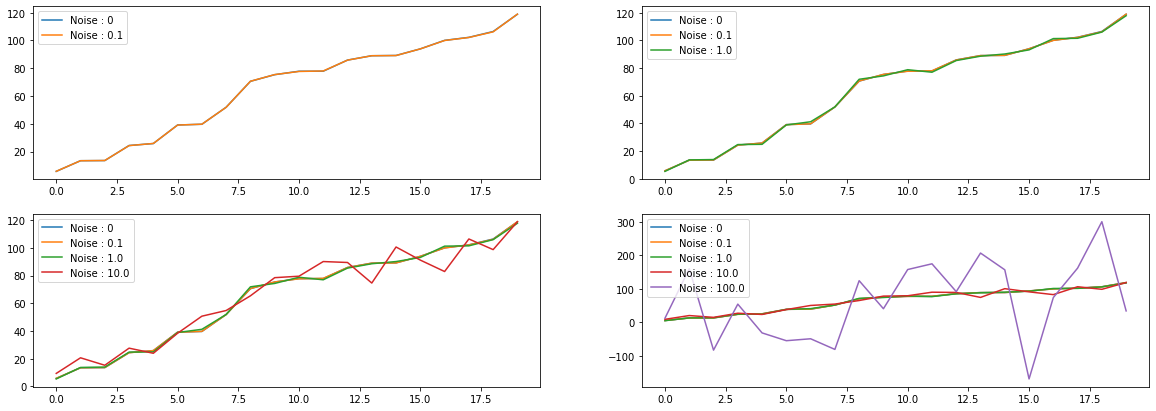

In [13]:
fig = plt.figure(figsize=(20, 7))

for iter in range(2, len(X_ts_main) + 1) :
  ax = fig.add_subplot(2, 2, iter - 1)
  X_plot = [i for i in range(20)]
  for index in range(iter) :
    plt.plot(X_plot, X_ts_main[index][0][0 : 20], label = f'Noise : {noise_list[index]}')
  plt.legend()
plt.show()

Здесь выделяются признаки, за исключением тех, которые очень долго извлекаются

In [ ]:
params = []
bad_params = [32, 35, 44, 45, 57, 62, 69, 71, 72, 73]
for elem in ComprehensiveFCParameters() :
  params.append(elem)

settings = ComprehensiveFCParameters()

for bad_param in bad_params :
  del settings[params[bad_param]]

X = extract_features(X, column_id=1, default_fc_parameters=settings, n_jobs = 10)
Y = pd.Series(Neuron_types)

Feature Extraction: 100%|██████████| 50/50 [09:22<00:00, 11.26s/it]


In [ ]:
X_main = [X.copy()]
for i in range(1, len(X_ts_main)) :
  X_main.append(extract_features(X_ts_main[i], column_id=1, default_fc_parameters=settings, n_jobs = 10))

Feature Extraction: 100%|██████████| 50/50 [10:24<00:00, 12.48s/it]


In [ ]:
tsfresh.utilities.dataframe_functions.impute(X)

In [ ]:
X_main[0] = X.copy()
for i in range(1, len(X_main)) :
  tsfresh.utilities.dataframe_functions.impute(X_main[i])

##Обучение

In [ ]:
Models = [
          ['Случайный лес (n = 10)', Rand_Forest(10)],
          ['Случайный лес (n = 100)', Rand_Forest(100)],
          ['Линейная классификация', Linear()],
          ['KNN (k = 2, p = 2)', KNN(2, p=2)],
          ['KNN (k = 5, p = 1)', KNN(5, p=1)],
          ['KNN (k = 1, p = 1)', KNN(1, p=1)]
]

In [ ]:
import random

Valid_number = 5
N_tests = 5

Part_size = [int(len(X) / Valid_number)] * (Valid_number - 1)
Part_size += [len(X) - sum(Part_size)]

Part_indexes = []
for i in range(Valid_number):
  Part_indexes.append([])

Not_full_parts = [i for i in range(Valid_number)]

###Случайный выбор обучающей выборки

In [ ]:
Accuracy = []

for model_count in range(len(Models)) :
  Accuracy.append([])
  for noise_count in range(len(noise_list)) :
    Accuracy[-1].append([])
    for test_count in range(N_tests) :
      Accuracy[-1][-1].append(0)


for test_count in range(N_tests) :

  print(f'Test_count : {test_count}')

  for i in range(Valid_number):
    Part_indexes[i] = []
  Not_full_parts = [i for i in range(Valid_number)]

  for i in range(len(X)):
    part = random.choice(Not_full_parts)
    Part_indexes[part].append(i)
    if (len(Part_indexes[part]) == Part_size[part]):
      Not_full_parts.remove(part)

  for valid_count in range(Valid_number) :

    print(f'  Valid_count : {valid_count}')

    Test_indexes = Part_indexes[valid_count]
    Train_indexes = []
    for i in range(len(Part_indexes)):
      if i == valid_count:
        continue
      Train_indexes += Part_indexes[i]

    Y_train = Y[Train_indexes]
    Y_test = Y[Test_indexes]
    Y_train.index = [i for i in range(len(Y_train))]
    Y_test.index = [i for i in range(len(Y_test))]

    for noise_count in range(len(noise_list)) :

      print(f'    Noise_count : {noise_count}')
    
      X_train = X_main[0].loc[Train_indexes]
      X_test = X_main[noise_count].loc[Test_indexes]
      X_train.index = [i for i in range(len(X_train))]
      X_test.index = [i for i in range(len(X_test))]


      for model_count in range(len(Models)):
        Model = Models[model_count][1]
        reg = Model.fit(X_train, Y_train)

        Accuracy[model_count][noise_count][test_count] += reg.score(X_test, Y_test) / Valid_number


Test_count : 0
  Valid_count : 0
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 1
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 2
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 3
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 4
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
Test_count : 1
  Valid_count : 0
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 1
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 2
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 3
    Nois

In [ ]:
for model_count in range(len(Models)) :

  print()
  print(f'{Models[model_count][0]} : ')
  
  for noise_count in range(len(noise_list)) :

    print(f'  Noise : {noise_list[noise_count]}')
    print(f'    Accuracy = {sum(Accuracy[model_count][noise_count]) / N_tests}')


Случайный лес (n = 10) : 
  Noise : 0
    Accuracy = 0.9271145728643215
  Noise : 0.1
    Accuracy = 0.9273206030150754
  Noise : 1.0
    Accuracy = 0.9118783919597989
  Noise : 10.0
    Accuracy = 0.9104603015075377
  Noise : 100.0
    Accuracy = 0.8959959798994974

Случайный лес (n = 100) : 
  Noise : 0
    Accuracy = 0.9335427135678392
  Noise : 0.1
    Accuracy = 0.933542713567839
  Noise : 1.0
    Accuracy = 0.9058412060301508
  Noise : 10.0
    Accuracy = 0.9076462311557789
  Noise : 100.0
    Accuracy = 0.9118703517587938

Линейная классификация : 
  Noise : 0
    Accuracy = 0.886764824120603
  Noise : 0.1
    Accuracy = 0.9176763819095479
  Noise : 1.0
    Accuracy = 0.8952010050251257
  Noise : 10.0
    Accuracy = 0.9158713567839195
  Noise : 100.0
    Accuracy = 0.9132643216080402

KNN (k = 2, p = 2) : 
  Noise : 0
    Accuracy = 0.8732824120603014
  Noise : 0.1
    Accuracy = 0.8732824120603014
  Noise : 1.0
    Accuracy = 0.8732824120603014
  Noise : 10.0
    Accuracy = 0.

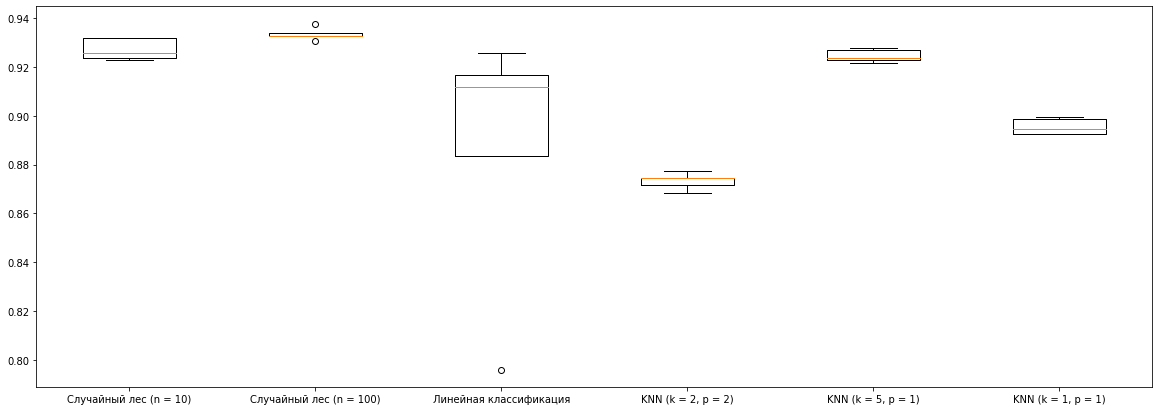

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 1, 1)

ax.boxplot((Accuracy[0][0],
            Accuracy[1][0],
            Accuracy[2][0],
            Accuracy[3][0],
            Accuracy[4][0],
            Accuracy[5][0]),
            labels=[Models[0][0],
                    Models[1][0],
                    Models[2][0],
                    Models[3][0],
                    Models[4][0],
                    Models[5][0]])


plt.show()

Случайный лес (n = 10)


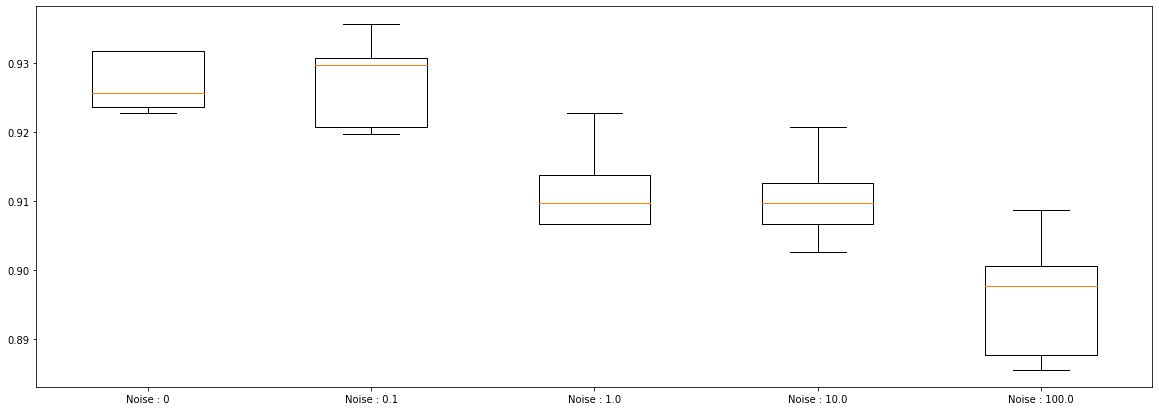

Случайный лес (n = 100)


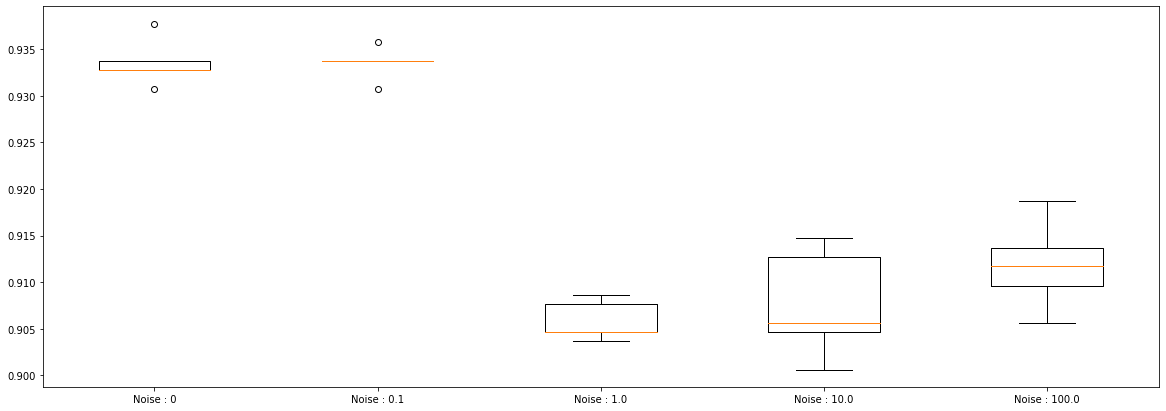

Линейная классификация


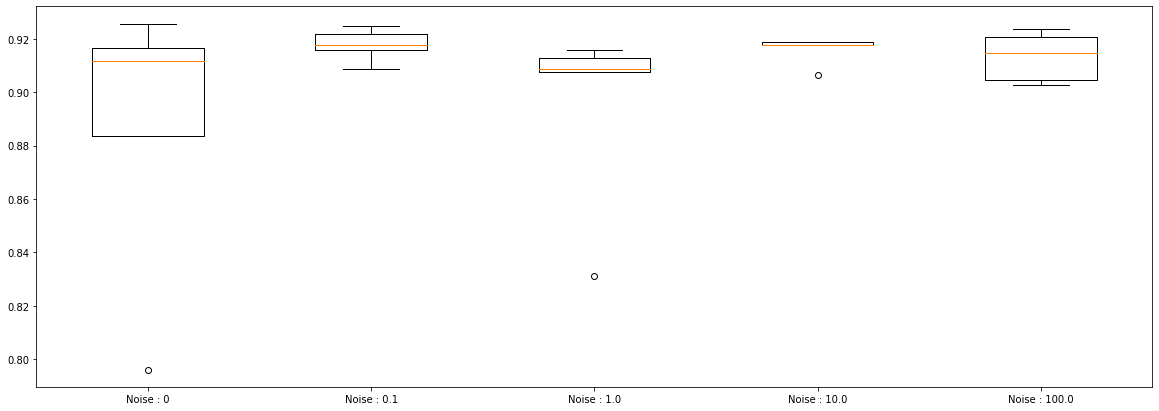

KNN (k = 2, p = 2)


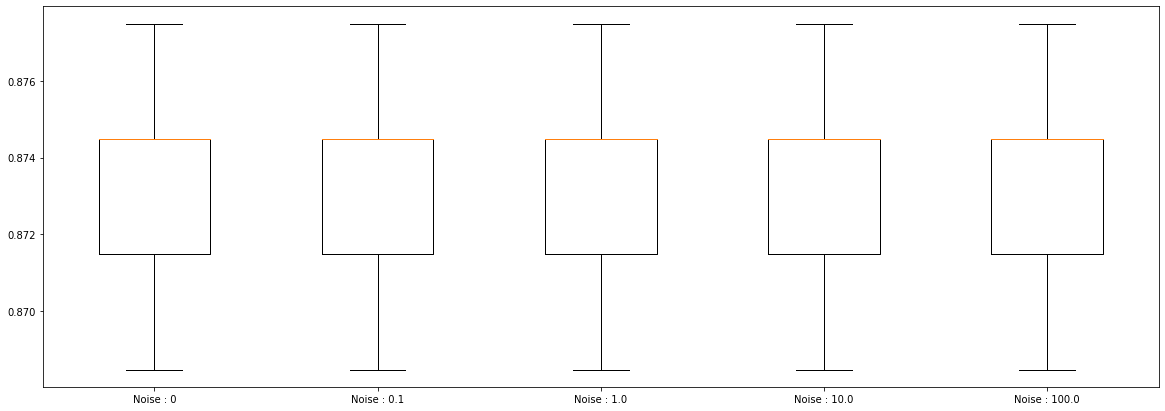

KNN (k = 5, p = 1)


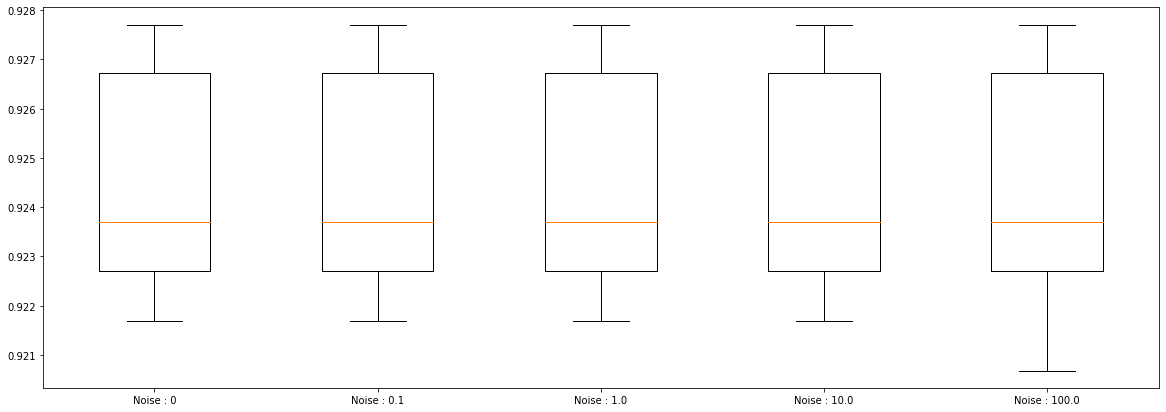

KNN (k = 1, p = 1)


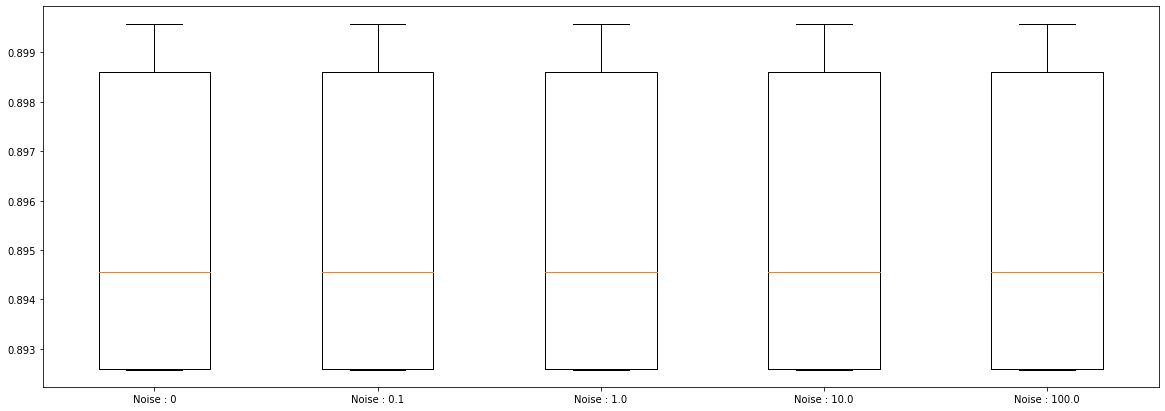

In [ ]:
for model_count in range(len(Models)) :

  print(Models[model_count][0])

  fig = plt.figure(figsize=(20, 7))
  ax = fig.add_subplot(1, 1, 1) 

  ax.boxplot((Accuracy[model_count][0],
              Accuracy[model_count][1],
              Accuracy[model_count][2],
              Accuracy[model_count][3],
              Accuracy[model_count][4]),
              labels=[f'Noise : {noise_list[0]}',
                      f'Noise : {noise_list[1]}',
                      f'Noise : {noise_list[2]}',
                      f'Noise : {noise_list[3]}',
                      f'Noise : {noise_list[4]}'])
  plt.show()

###Беру в обучающую выборку равномерно из разных животных

In [ ]:
Accuracy = []

for model_count in range(len(Models)) :
  Accuracy.append([])
  for noise_count in range(len(noise_list)) :
    Accuracy[-1].append([])
    for test_count in range(N_tests) :
      Accuracy[-1][-1].append(0)


for test_count in range(N_tests) :

  print(f'Test_count : {test_count}')

  Part_size = []
  for i in range(Valid_number) :
    Part_size.append([])

  for i in range(len(Dataset_size)) :
    for j in range(Valid_number - 1) :
      Part_size[j] += [int(Dataset_size[i] / Valid_number)]
    Part_size[-1] += [Dataset_size[i] - sum(Part_size[j])]

  Part_indexes = []
  for i in range(Valid_number):
    Part_indexes.append([])

  Not_full_parts = [i for i in range(Valid_number)]


  for j in range(len(Dataset_size)) :
    for i in range(Dataset_size[j]):
      part = random.choice(Not_full_parts)
      Part_indexes[part].append(i + sum(Dataset_size[0:j]))
      if (len(Part_indexes[part]) == Part_size[part]):
        Not_full_parts.remove(part)

  for valid_count in range(Valid_number) :

    print(f'  Valid_count : {valid_count}')

    Test_indexes = Part_indexes[valid_count]
    Train_indexes = []
    for i in range(len(Part_indexes)):
      if i == valid_count:
        continue
      Train_indexes += Part_indexes[i]

    Y_train = Y[Train_indexes]
    Y_test = Y[Test_indexes]
    Y_train.index = [i for i in range(len(Y_train))]
    Y_test.index = [i for i in range(len(Y_test))]

    for noise_count in range(len(noise_list)) :

      print(f'    Noise_count : {noise_count}')
    
      X_train = X_main[0].loc[Train_indexes]
      X_test = X_main[noise_count].loc[Test_indexes]
      X_train.index = [i for i in range(len(X_train))]
      X_test.index = [i for i in range(len(X_test))]


      for model_count in range(len(Models)):
        Model = Models[model_count][1]
        reg = Model.fit(X_train, Y_train)

        Accuracy[model_count][noise_count][test_count] += reg.score(X_test, Y_test) / Valid_number


Test_count : 0
  Valid_count : 0
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 1
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 2
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 3
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 4
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
Test_count : 1
  Valid_count : 0
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 1
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 2
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 3
    Nois

In [ ]:
for model_count in range(len(Models)) :

  print()
  print(f'{Models[model_count][0]} : ')
  
  for noise_count in range(len(noise_list)) :

    print(f'  Noise : {noise_list[noise_count]}')
    print(f'    Accuracy = {sum(Accuracy[model_count][noise_count]) / N_tests}')


Случайный лес (n = 10) : 
  Noise : 0
    Accuracy = 0.9286613271319561
  Noise : 0.1
    Accuracy = 0.925135634463716
  Noise : 1.0
    Accuracy = 0.9048233593517769
  Noise : 10.0
    Accuracy = 0.9119010326121237
  Noise : 100.0
    Accuracy = 0.8982931094147297

Случайный лес (n = 100) : 
  Noise : 0
    Accuracy = 0.934746193367148
  Noise : 0.1
    Accuracy = 0.9330740254796043
  Noise : 1.0
    Accuracy = 0.9054304779581983
  Noise : 10.0
    Accuracy = 0.9053108986253772
  Noise : 100.0
    Accuracy = 0.9116945961455428

Линейная классификация : 
  Noise : 0
    Accuracy = 0.9134070769884461
  Noise : 0.1
    Accuracy = 0.9033838712305734
  Noise : 1.0
    Accuracy = 0.9124452559033408
  Noise : 10.0
    Accuracy = 0.9100864122295089
  Noise : 100.0
    Accuracy = 0.9098665141028341

KNN (k = 2, p = 2) : 
  Noise : 0
    Accuracy = 0.871728160525846
  Noise : 0.1
    Accuracy = 0.871728160525846
  Noise : 1.0
    Accuracy = 0.871728160525846
  Noise : 10.0
    Accuracy = 0.871

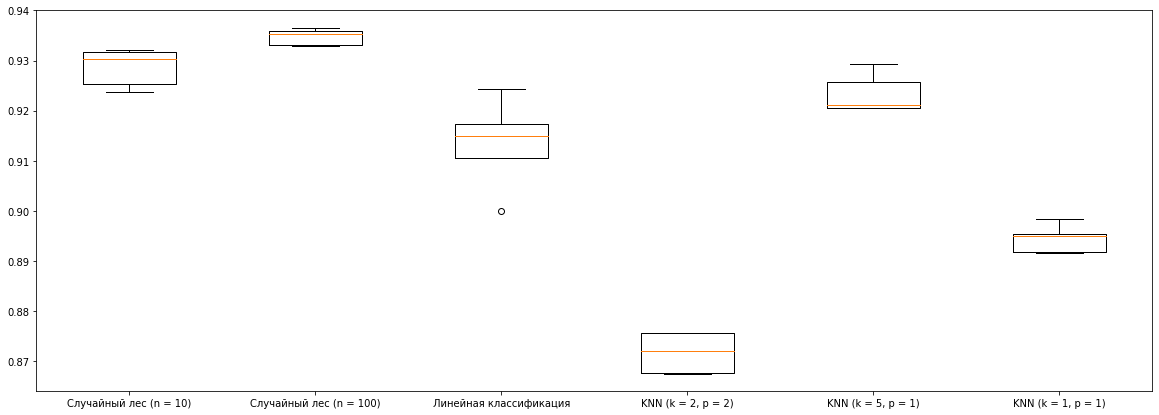

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 1, 1)

ax.boxplot((Accuracy[0][0],
            Accuracy[1][0],
            Accuracy[2][0],
            Accuracy[3][0],
            Accuracy[4][0],
            Accuracy[5][0]),
            labels=[Models[0][0],
                    Models[1][0],
                    Models[2][0],
                    Models[3][0],
                    Models[4][0],
                    Models[5][0]])


plt.show()

###Беру 2 животных для обучающей, остальное в тестовую

In [ ]:
Accuracy = []

for model_count in range(len(Models)) :
  Accuracy.append([])
  for noise_count in range(len(noise_list)) :
    Accuracy[-1].append([])
    for test_count in range(N_tests) :
      Accuracy[-1][-1].append(0)


for test_count in range(N_tests) :

  print(f'Test_count : {test_count}')

  Train_number = 2

  Part_indexes = []
  for i in range(Valid_number):
    Part_indexes.append([])

  for i in range(Valid_number) :
    parts = [k for k in range(len(Dataset_size))]
    for j in range(Train_number) :
      part = random.choice(parts)
      parts.remove(part)
      Part_indexes[i] += [k + sum(Dataset_size[0:part]) for k in range(Dataset_size[part])]

  for valid_count in range(Valid_number) :

    print(f'  Valid_count : {valid_count}')

    Test_indexes = Part_indexes[valid_count]
    Train_indexes = []
    for i in range(len(Part_indexes)):
      if i == valid_count:
        continue
      Train_indexes += Part_indexes[i]

    Y_train = Y[Train_indexes]
    Y_test = Y[Test_indexes]
    Y_train.index = [i for i in range(len(Y_train))]
    Y_test.index = [i for i in range(len(Y_test))]

    for noise_count in range(len(noise_list)) :

      print(f'    Noise_count : {noise_count}')
    
      X_train = X_main[0].loc[Train_indexes]
      X_test = X_main[noise_count].loc[Test_indexes]
      X_train.index = [i for i in range(len(X_train))]
      X_test.index = [i for i in range(len(X_test))]


      for model_count in range(len(Models)):
        Model = Models[model_count][1]
        reg = Model.fit(X_train, Y_train)

        Accuracy[model_count][noise_count][test_count] += reg.score(X_test, Y_test) / Valid_number


Test_count : 0
  Valid_count : 0
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 1
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 2
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 3
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 4
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
Test_count : 1
  Valid_count : 0
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 1
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 2
    Noise_count : 0
    Noise_count : 1
    Noise_count : 2
    Noise_count : 3
    Noise_count : 4
  Valid_count : 3
    Nois

In [ ]:
for model_count in range(len(Models)) :

  print()
  print(f'{Models[model_count][0]} : ')
  
  for noise_count in range(len(noise_list)) :

    print(f'  Noise : {noise_list[noise_count]}')
    print(f'    Accuracy = {sum(Accuracy[model_count][noise_count]) / N_tests}')


Случайный лес (n = 10) : 
  Noise : 0
    Accuracy = 0.9318967931040476
  Noise : 0.1
    Accuracy = 0.9261211631696042
  Noise : 1.0
    Accuracy = 0.9188931900340342
  Noise : 10.0
    Accuracy = 0.9049763764926156
  Noise : 100.0
    Accuracy = 0.8771804379750698

Случайный лес (n = 100) : 
  Noise : 0
    Accuracy = 0.9459973343618782
  Noise : 0.1
    Accuracy = 0.9429632506591258
  Noise : 1.0
    Accuracy = 0.9004743456112054
  Noise : 10.0
    Accuracy = 0.8922943962893604
  Noise : 100.0
    Accuracy = 0.9018567453347682

Линейная классификация : 
  Noise : 0
    Accuracy = 0.8888621404306644
  Noise : 0.1
    Accuracy = 0.9194629711467541
  Noise : 1.0
    Accuracy = 0.8931633014220297
  Noise : 10.0
    Accuracy = 0.9068740693670575
  Noise : 100.0
    Accuracy = 0.9059020438589727

KNN (k = 2, p = 2) : 
  Noise : 0
    Accuracy = 0.8777055105380134
  Noise : 0.1
    Accuracy = 0.8777055105380134
  Noise : 1.0
    Accuracy = 0.8777055105380134
  Noise : 10.0
    Accuracy = 

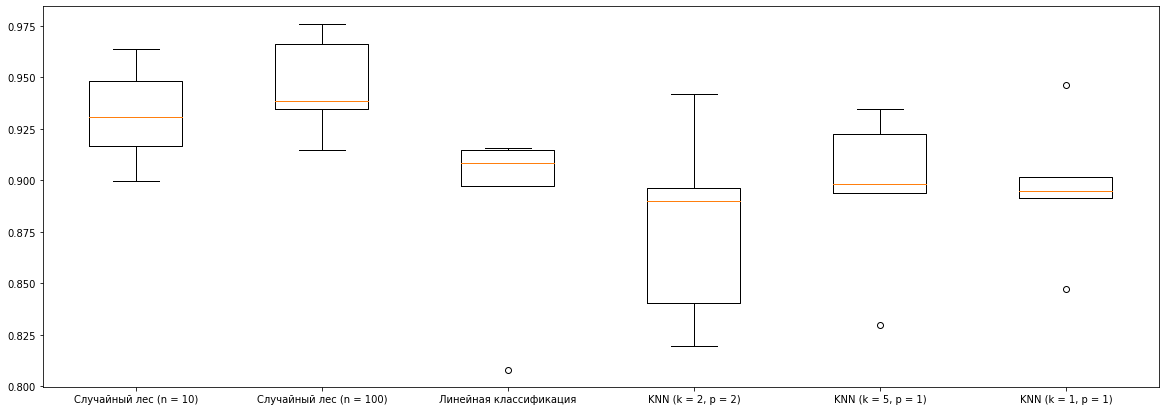

In [ ]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 1, 1)

ax.boxplot((Accuracy[0][0],
            Accuracy[1][0],
            Accuracy[2][0],
            Accuracy[3][0],
            Accuracy[4][0],
            Accuracy[5][0]),
            labels=[Models[0][0],
                    Models[1][0],
                    Models[2][0],
                    Models[3][0],
                    Models[4][0],
                    Models[5][0]])


plt.show()